In [69]:
%matplotlib inline

import os
import glob
from functools import partial

import cv2 as cv
import matplotlib.pyplot as plt

from hep2_classification.preprocessing import preprocess

from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.model_selection import train_test_split

import numpy as np

from matplotlib.colors import ListedColormap
import pickle

In [2]:
data_dir = '../../data/original/'
files = glob.glob(data_dir + '/*/*.tif')
print(len(files))
files[:10]

1182


['../data/original/negatives/NEG3-3.tif',
 '../data/original/negatives/NEG5-15.tif',
 '../data/original/negatives/NEG1-12.tif',
 '../data/original/negatives/NEG5-18.tif',
 '../data/original/negatives/NEG2-6.tif',
 '../data/original/negatives/NEG6-1.tif',
 '../data/original/negatives/NEG7-17.tif',
 '../data/original/negatives/NEG7-19.tif',
 '../data/original/negatives/NEG2-14.tif',
 '../data/original/negatives/NEG1-17.tif']

In [3]:
negatives_files = [f for f in files if 'NEG' in f]
positives_files = [f for f in files if 'NEG' not in f]

len(negatives_files), len(positives_files)

(180, 1002)

In [4]:
%%time
neg_imgs = np.array([preprocess(cv.imread(f), normalize=False, equalize=False) for f in negatives_files])
pos_imgs = np.array([preprocess(cv.imread(f), normalize=False, equalize=False) for f in positives_files])

neg_imgs.shape, pos_imgs.shape

CPU times: user 14min 46s, sys: 3.59 s, total: 14min 50s
Wall time: 3min 57s


In [5]:
pos_means = np.mean(pos_imgs.reshape(pos_imgs.shape[0], -1), axis=1)
neg_means = np.mean(neg_imgs.reshape(neg_imgs.shape[0], -1), axis=1)

pos_stds = np.std(pos_imgs.reshape(pos_imgs.shape[0], -1), axis=1)
neg_stds = np.std(neg_imgs.reshape(neg_imgs.shape[0], -1), axis=1)

In [6]:
means = np.concatenate([neg_means, pos_means])
stds = np.concatenate([neg_stds, pos_stds])

X = np.column_stack([means, stds])
y = np.array([0] * len(neg_imgs) + [1] * len(pos_imgs))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

### data visualization

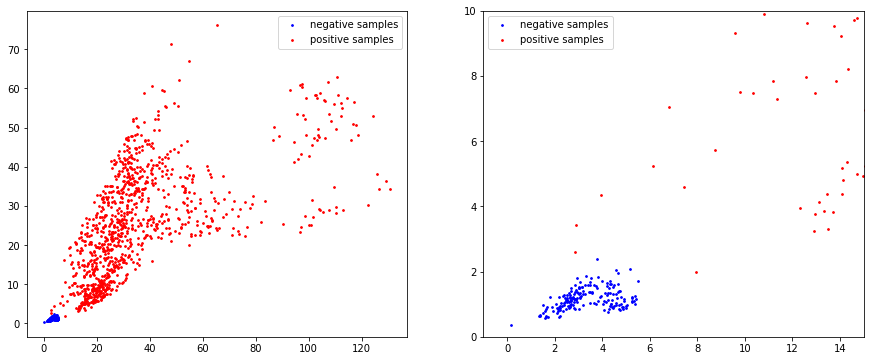

In [11]:
f, a = plt.subplots(1, 2)
f.set_size_inches(15, 6)

for ax in a:
    ax.scatter(neg_means, neg_stds, c='blue', s=3, label='negative samples')
    ax.scatter(pos_means, pos_stds, c='red', s=3, label='positive samples')
    ax.xaxis.set_label('mean pixel intentity')
    ax.yaxis.set_label('pixel intensity std')
    ax.legend()
    
a[1].set_xlim(-1, 15)
a[1].set_ylim(0, 10)

plt.show()

### classifier

In [66]:
classifier = svm.SVC(C=0.9, kernel='poly', degree=2, gamma=0.35)
classifier.fit(X_train, y_train)

SVC(C=0.9, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=2, gamma=0.35, kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

### decision boundary

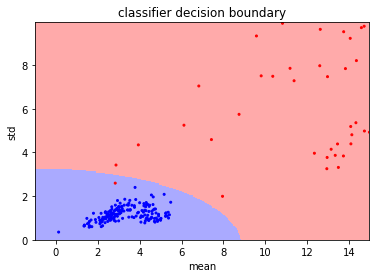

In [67]:
h = 0.05

cmap_light = ListedColormap(['#AAAAFF', '#FFAAAA'])
cmap_bold = ListedColormap(['#0000FF', '#FF0000'])

x_min, x_max = -1, 15
y_min, y_max = 0, 10

xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, s=4)

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title('classifier decision boundary')
plt.xlabel('mean')
plt.ylabel('std')
plt.show()

### results

In [68]:
train_preds = classifier.predict(X_train)
test_preds = classifier.predict(X_test)

train_acc = np.mean(train_preds == y_train)
test_acc = np.mean(test_preds == y_test)

print(f'train accuracy: {train_acc}')
print(f'test accuracy: {test_acc}')

train accuracy: 0.9987908101571947
test accuracy: 1.0


### save classifier

In [73]:
serialized = pickle.dumps(classifier)
with open(..., 'wb') as classifier_file: # set proper filename, careful not to overwrite another model
    classifier_file.write(serialized)

In [75]:
with open('./negatives-classifier.bin', 'rb') as cf:
    reloaded = pickle.loads(cf.read())

rel_preds = reloaded.predict(X_test)
rel_acc = np.mean(rel_preds == y_test)
print(f'loaded model test accuracy: {rel_acc}')

loaded model test accuracy: 1.0
